## Step 1: Mounting the google drive

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


##Step 2: Import the FER2013 dataset from kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
# Downloading dataset directly from the kaggle
! kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge

100% 96.6M/96.6M [00:04<00:00, 22.9MB/s]
100% 96.6M/96.6M [00:04<00:00, 22.3MB/s]


In [ ]:
# Move the downloaded zip file to the destination folder in drive so that we won't to download it again
! mv /content/facial-expression-recognitionferchallenge.zip /content/MyDrive/MyDrive/Facial_Exp_Detection

In [ ]:
#change the directory
%cd /content/MyDrive/MyDrive/Facial_Exp_Detection
! pwd

/content/MyDrive/MyDrive/Facial_Exp_Detection


In [ ]:
# Unzip the zip file
! unzip facial-expression-recognitionferchallenge.zip

Archive:  facial-expression-recognitionferchallenge.zip
  inflating: Submission.csv          
  inflating: fer2013/fer2013/README  
  inflating: fer2013/fer2013/fer2013.bib  
  inflating: fer2013/fer2013/fer2013.csv  


##Step 3: Data Preprocessing<br>


1.   Load the data from csv file.
2.   Check whether the data is imbalanced or balanced
3.   Balance the data using image augmentation



In [2]:
# Importing required libraries to visualize and preprocess the data
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random

In [3]:
# Import the data directly from csv file. It will create a panadas dataframe
data = pd.read_csv('/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/fer2013/fer2013.csv')

In [ ]:
# First five rows of dataframe
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
# Array of distinct emotions
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
# Counts of data points corresponding to each emotion class
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
# Count of train / test / valid data
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
#Define a dictionary containing labels for the emotions
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
def pixels_label_gen(pixels, labels):
  """
    Generator function that yields pairs of image data and corresponding labels.

    Args:
        pixels (list): List of strings representing the pixel intensities of images.
        labels (list): List of labels corresponding to the images.

    Yields:
        tuple: A tuple containing the 2D image containing (48, 48) pixels and label.

    """
  for pixel, label in zip(pixels, labels):
    #print(len(pixel.split(' ')), label)
    yield (np.array(pixel.split(' ')).reshape(48, 48).astype('float32'), label)

In [ ]:
def show_image(data, rows):
  """
    Display images from the given dataset.

    Args:
        data (DataFrame): Pandas DataFrame containing the image pixel data and corresponding labels.
        rows (int): Number of rows of images to display.

    """
  # Create a figure with specified size
  fig = plt.figure(1, (14, 14))
  i=0 # Counter for the images
  data_generator = pixels_label_gen(data['pixels'], data['emotion'])
  limit = rows * 7 - 1 # Calculate the limit of images to display based on the number of rows
  for pixels, label in data_generator:
    i = i+1
    #print(pixels.shape)
    ax = plt.subplot(7, 7, i)
    ax.imshow(pixels, cmap='gray') # Display the image
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_labels[label]) # Set the title of the subplot as the corresponding emotion label
    plt.tight_layout()
    if i > limit:
      break # Break the loop if the limit of images is reached

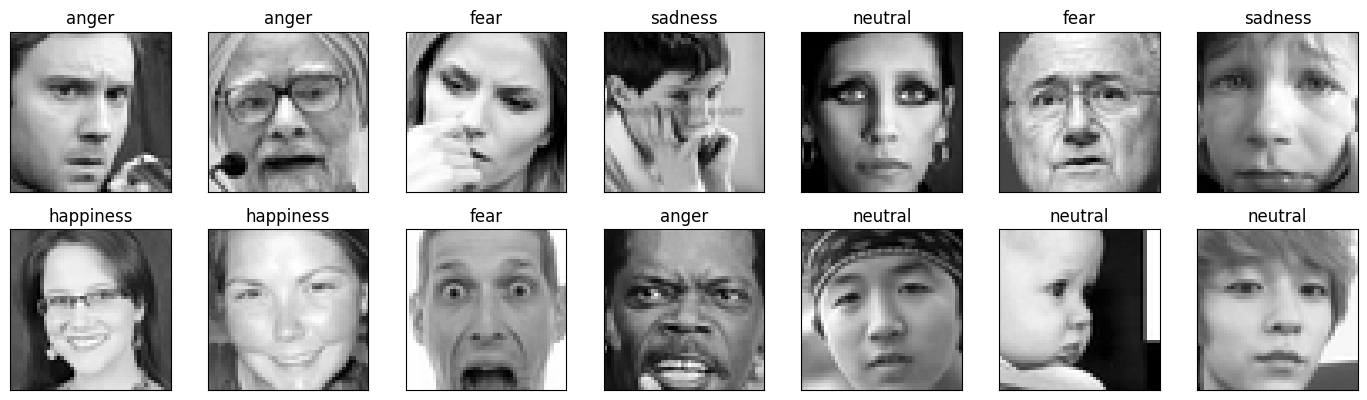

In [ ]:
show_image(data, 2)

In [ ]:
def horizontal_flip(image):
  """
    Perform a horizontal flip on the input image.

    Args:
        image (numpy.ndarray): Input image to be flipped.

    Returns:
        numpy.ndarray: Flipped image.

    """
  return cv2.flip(image, 1) # Perform horizontal flip using cv2.flip

In [ ]:
def vertical_flip(image):
  """
    Perform a vertical flip on the input image.

    Args:
        image (numpy.ndarray): Input image to be flipped.

    Returns:
        numpy.ndarray: Flipped image.

    """
  return cv2.flip(image, 0) # Perform vertical flip using cv2.flip

In [ ]:
def rotation(image, angle):
  """
    Apply a rotation transformation to the input image.

    Args:
        image (numpy.ndarray): Input image to be rotated.
        angle (float): Maximum angle of rotation in degrees.

    Returns:
        numpy.ndarray: Rotated image.

    """
  # Generate a random angle within the specified range
  angle = int(random.uniform(-angle, angle))

  # Get the height and width of the image
  h, w = image.shape[:2]

  # Compute the rotation matrix using the center of the image and the specified angle
  M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)

  # Apply the rotation transformation to the image
  image = cv2.warpAffine(image, M, (w, h))
  
  return image

In [ ]:
def augment_images(img, type):

  """
    Apply augmentation techniques to the input image based on the specified type.

    Args:
        img (numpy.ndarray): Input image to be augmented.
        type (str): Type of augmentation to apply ('hflip', 'vflip', or 'rotation').

    Returns:
        numpy.ndarray: Augmented image.

    """

  if type=='hflip':
     # Apply horizontal flip transformation
    return horizontal_flip(img)

  elif type=='vflip':
    # Apply vertical flip transformation
    return vertical_flip(img)

  else:
    # Apply rotation transformation with a random angle within the range of -90 to 90 degrees
    angle = random.uniform(-90, 90)
    return rotation(img, angle)

In [ ]:

def gen_balance_data(data, max_img_cnt, img_cnt, label):
  """
    Generate balanced data by augmenting the input data.

    Args:
        data (pandas.DataFrame): Input data to be balanced.
        max_img_cnt (int): Maximum number of images desired.
        img_cnt (int): Number of images in the input data.
        label (str): Label to assign to the augmented images.

    Returns:
        numpy.ndarray: Augmented images.

  """
  req_imgs = max_img_cnt - img_cnt
  #print('req_imgs', req_imgs)

  # Select randomly sampled samples if required images are less than or equal to current images
  randomly_selected_samples = data
  if req_imgs <= img_cnt:
    randomly_selected_samples = data.sample(n=req_imgs)
  else:
    factor = max_img_cnt // img_cnt # Number of times to repeat the input data (greater than 2)
    remains = max_img_cnt - img_cnt * factor # Remaining number of images to sample
    # Concatenate multiple copies of the input data and sample additional images
    randomly_selected_samples = pd.concat([pd.concat([data] * (factor-1), ignore_index = False, axis = 0) , data.sample(n=remains)], axis=0, ignore_index = False)
    #print('randomly_selected_samples.shape ', randomly_selected_samples.shape)
  

  #horizontal, vertical, right rotation
  random_imgs = randomly_selected_samples['pixels']

  # Initialize the array to store augmented images
  aug_imgs = np.full((req_imgs, 3), "", dtype=object)

  aug_types = ['hflip', 'vflip', 'rotation'] # Augmentation types

  k = 0 # Index to iterate through augmentation types
  #print(aug_imgs.shape, randomly_selected_samples.shape)

  for i, img in enumerate(random_imgs):
    if i%img_cnt==0 and i>0:
      #print('aug type selected {} i = {}'.format(aug_types[k], i))
      s = len(aug_types)
      k = (k+1)%s # Cycle through the augmentation types

    # Apply augmentation to the image based on the selected augmentation type
    flip_img = augment_images(np.array(img.split(' ')).reshape(48, 48).astype('float32'), aug_types[k])
    flip_img_pixels = flip_img.reshape(2304, ).astype(str)
    flip_img_str = ' '.join(flip_img_pixels)
    
    # Store the augmented image, label, and category in the array
    aug_imgs[i][0] = label
    aug_imgs[i][1] = flip_img_str
    aug_imgs[i][2] = "Training"
    
  return aug_imgs



In [ ]:
def balance_data(data):
  """
    Balance the data by generating additional samples for classes with fewer samples.

    Args:
        data (pandas.DataFrame): Input data containing emotion labels and image pixels.

    Returns:
        pandas.DataFrame: Balanced data with additional samples.

    """

  bal_data = data.copy() # Create a copy of the input data

  max_class_count = data['emotion'].value_counts().max() # Find the maximum count of samples among all emotion classes

  emotions = list(data.emotion.unique()) # Get the list of unique emotion classes

  #print(max_class_count)
  for cl in emotions:
    #print(cl)
    cl_data = data[data['emotion']==cl] # Filter data for the current emotion class

    #print(cl_data.head())
    class_count = cl_data['emotion'].count() # Count the number of samples for 
    #print(class_count)

    if class_count < max_class_count:
      # Generate additional samples for the current class using gen_balance_data function
      aug_data = gen_balance_data(cl_data, max_class_count, class_count, cl)

       # Create a DataFrame from the augmented data and append it to the balanced data
      df = pd.DataFrame(aug_data, columns=['emotion', 'pixels', 'Usage'])
      #print(df.shape)
      bal_data = bal_data.append(df, ignore_index=True)
      
  return bal_data

In [ ]:
data_frame  = balance_data(data) #call the balance_data method to generate the balanced data
print(data_frame.shape)

0
4953
req_imgs 4036
(4036, 3) (4036, 3)
(4036, 3)
2
5121
req_imgs 3868
(3868, 3) (3868, 3)


<ipython-input-70-d18e3787e0bf>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df, ignore_index=True)


(3868, 3)
4
6077
req_imgs 2912
(2912, 3) (2912, 3)


<ipython-input-70-d18e3787e0bf>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df, ignore_index=True)


(2912, 3)
6
6198
req_imgs 2791
(2791, 3) (2791, 3)


<ipython-input-70-d18e3787e0bf>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df, ignore_index=True)


(2791, 3)
3
8989
5
4002
req_imgs 4987
randomly_selected_samples.shape  (4987, 3)
(4987, 3) (4987, 3)


<ipython-input-70-d18e3787e0bf>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df, ignore_index=True)


aug type selected hflip i = 4002
(4987, 3)
1
547
req_imgs 8442
randomly_selected_samples.shape  (8442, 3)
(8442, 3) (8442, 3)


<ipython-input-70-d18e3787e0bf>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df, ignore_index=True)


aug type selected hflip i = 547
aug type selected vflip i = 1094
aug type selected rotation i = 1641
aug type selected hflip i = 2188
aug type selected vflip i = 2735
aug type selected rotation i = 3282
aug type selected hflip i = 3829
aug type selected vflip i = 4376
aug type selected rotation i = 4923
aug type selected hflip i = 5470
aug type selected vflip i = 6017
aug type selected rotation i = 6564
aug type selected hflip i = 7111
aug type selected vflip i = 7658
aug type selected rotation i = 8205
(8442, 3)
(62923, 3)


<ipython-input-70-d18e3787e0bf>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df, ignore_index=True)


In [ ]:
# Write data to csv files for furthur use
data_frame.to_csv('/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/fer2013/fer2013_balanced.csv', index=False)

In [ ]:
# Counts of balanced data 
data_frame.Usage.value_counts()

Training       55745
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
train_data = data_frame[data_frame['Usage']=='Training'] # training set
valid_data = data_frame[data_frame['Usage']=='PublicTest'] # validation set
test_data = data_frame[data_frame['Usage']=='PrivateTest'] # test set

In [ ]:
# Counts of emotion classes in training set
train_data.emotion.value_counts()

1    8878
5    8158
0    8031
2    7965
6    7756
4    7742
3    7215
Name: emotion, dtype: int64

## Step 4: Model(s) Training

In [4]:
! pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
# Import the required libararies
import math
import numpy as np
import pandas as pd
import cv2

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D, GlobalMaxPool2D
from keras.layers import Dropout, BatchNormalization, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [6]:
# Read saved data in csv file 
data_frame = pd.read_csv('/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/fer2013/fer2013_balanced.csv')

In [7]:
train_data = data_frame[data_frame['Usage']=='Training'] # Training set
valid_data = data_frame[data_frame['Usage']=='PublicTest'] # Validation set
test_data = data_frame[data_frame['Usage']=='PrivateTest'] # Test set

In [8]:
def get_img_dim(string):
  """
    Convert a string representation of an image to a NumPy array.

    Args:
        string (str): String representation of an image, where pixel values are separated by spaces.

    Returns:
        numpy.ndarray: NumPy array representing the image.

    """
  return np.array(string.split(' ')).reshape(48, 48).astype('float32')

In [9]:
# Convert the pixel values in the 'pixels' column of the train_data DataFrame into NumPy arrays representing the images
# Assign the converted arrays to the X_train variable
X_train = train_data['pixels'].apply(get_img_dim)

# Assign the emotion labels from the 'emotion' column of the train_data DataFrame to the Y_train variable
Y_train = train_data['emotion']

# Convert the pixel values in the 'pixels' column of the valid_data DataFrame into NumPy arrays representing the images
# Assign the converted arrays to the X_valid variable
X_valid = valid_data['pixels'].apply(get_img_dim)

# Assign the emotion labels from the 'emotion' column of the valid_data DataFrame to the Y_valid variable
Y_valid = valid_data['emotion']

# Convert the pixel values in the 'pixels' column of the test_data DataFrame into NumPy arrays representing the images
# Assign the converted arrays to the X_test variable
X_test = test_data['pixels'].apply(get_img_dim)

# Assign the emotion labels from the 'emotion' column of the test_data DataFrame to the Y_test variable
Y_test= test_data['emotion']

In [10]:
# Normalize the pixel values in X_train, X_valid, and X_test by dividing them by 255
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

In [11]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the emotion labels in Y_train using label_encoder
Y_train = label_encoder.fit_transform(Y_train)
# Convert the encoded labels to one-hot encoded vectors
Y_train = np_utils.to_categorical(Y_train)

# Encode the emotion labels in Y_valid using label_encoder
Y_valid = label_encoder.fit_transform(Y_valid)
# Convert the encoded labels to one-hot encoded vectors
Y_valid = np_utils.to_categorical(Y_valid)

# Encode the emotion labels in Y_test using label_encoder
Y_test = label_encoder.fit_transform(Y_test)
# Convert the encoded labels to one-hot encoded vectors
Y_test = np_utils.to_categorical(Y_test)

In [12]:
print('X_train.shape {},  Y_train.shape {}'.format(X_train.shape, Y_train.shape))
print('X_valid.shape {},  Y_valid.shape {}'.format(X_valid.shape, Y_valid.shape))
print('X_test.shape {},  Y_test.shape {}'.format(X_test.shape, Y_test.shape))

X_train.shape (55745,),  Y_train.shape (55745, 7)
X_valid.shape (3589,),  Y_valid.shape (3589, 7)
X_test.shape (3589,),  Y_test.shape (3589, 7)


In [13]:
def get_RGB_img(img):
  """
    Converts a grayscale image to RGB format.

    Parameters:
    - img: Grayscale image to be converted.

    Returns:
    - RGB image.
    """
  return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

In [14]:
# Convert grayscale images in X_train to RGB format and stack them into a 4D array
x_train, y_train = np.stack(X_train.apply(lambda x:  cv2.cvtColor(x, cv2.COLOR_GRAY2RGB))), Y_train

# Convert grayscale images in X_valid to RGB format and stack them into a 4D array
x_valid, y_valid = np.stack(X_valid.apply(lambda x:  cv2.cvtColor(x, cv2.COLOR_GRAY2RGB))), Y_valid

# Convert grayscale images in X_test to RGB format and stack them into a 4D array
x_test, y_test = np.stack(X_test.apply(lambda x:  cv2.cvtColor(x, cv2.COLOR_GRAY2RGB))), Y_test

In [15]:
print('x_train.shape {},  y_train.shape {}'.format(x_train.shape, y_train.shape))
print('x_valid.shape {},  y_valid.shape {}'.format(x_valid.shape, y_valid.shape))
print('x_test.shape {},  y_test.shape {}'.format(x_test.shape, y_test.shape))

x_train.shape (55745, 48, 48, 3),  y_train.shape (55745, 7)
x_valid.shape (3589, 48, 48, 3),  y_valid.shape (3589, 7)
x_test.shape (3589, 48, 48, 3),  y_test.shape (3589, 7)


##VGG 19 Architecture <br>
A VGG19 model is created using the tf.keras.applications.VGG19 function. The parameters used in creating the model are:

*  weights='imagenet': Specifies that the pre-trained weights of the VGG19 model trained on the ImageNet dataset should be used.
*  include_top=False: Indicates that the top (fully connected) layers of the VGG19 model should not be included. This is often done when using the pre-trained model as a feature extractor.
*  input_shape=(48, 48, 3): Specifies the input shape of the model. The VGG19 model expects input images of size 48x48 pixels with 3 channels (RGB).








In [ ]:
# Create a VGG19 model with pre-trained weights from ImageNet
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
def build_model(base_model, classes):
    # Extract the output of the second-to-last layer of the bottom model
    model = base_model.layers[-2].output

    # Apply Global Average Pooling to reduce spatial dimensions
    model = GlobalAveragePooling2D()(model)

    # Add a Dense layer with softmax activation as the output layer
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [ ]:
num_classes = 7 # No. of classes

#Initialize output layer
output = build_model(vgg, num_classes)

# Create a new model by specifying the inputs and outputs
model = Model(inputs = vgg.input, outputs = output)

# Print the summary of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Metric to monitor for early stopping
    min_delta=0.00005,                 # Minimum change in the monitored metric to be considered as improvement
    patience=11,                       # Number of epochs with no improvement after which training will be stopped
    verbose=1,                         # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
    restore_best_weights=True          # Whether to restore model weights from the epoch with the best monitored metric
)

# Create a ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',            # Metric to monitor for learning rate adjustment
    factor=0.5,                        # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=7,                        # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                       # Lower bound on the learning rate
    verbose=1                          # Verbosity mode. 0 = silent, 1 = update messages
)

# Combine the callbacks into a list
callbacks = [early_stopping, lr_scheduler]


In [ ]:
batch_size = 5 # Number of samples processed in each training iteration
epochs = 10 # Number of times the entire dataset will be passed through the model during training

# Define the optimizer(s) to be used
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

In [ ]:
def compile_model(optimizer, model):
  model.compile(loss = 'categorical_crossentropy', # Loss function for multi-class classification
              optimizer = optimizer, # Selected optimizer from the optims list
              metrics = ['accuracy']) # Evaluation metric(s) to be computed during training
  return model

In [ ]:
model = compile_model(optims, model)

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size,
                                       validation_data = (x_valid, y_valid),
                                       steps_per_epoch = len(x_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/25
1742/1742 [==============================] - 104s 53ms/step - loss: 1.3973 - accuracy: 0.4509 - val_loss: 1.2429 - val_accuracy: 0.5339 - lr: 1.0000e-04
Epoch 2/25
1742/1742 [==============================] - 95s 55ms/step - loss: 0.9937 - accuracy: 0.6225 - val_loss: 1.0704 - val_accuracy: 0.5968 - lr: 1.0000e-04
Epoch 3/25
1742/1742 [==============================] - 94s 54ms/step - loss: 0.8417 - accuracy: 0.6823 - val_loss: 1.0594 - val_accuracy: 0.6113 - lr: 1.0000e-04
Epoch 4/25
1742/1742 [==============================] - 94s 54ms/step - loss: 0.7278 - accuracy: 0.7256 - val_loss: 0.9969 - val_accuracy: 0.6272 - lr: 1.0000e-04
Epoch 5/25
1742/1742 [==============================] - 95s 54ms/step - loss: 0.6331 - accuracy: 0.7653 - val_loss: 1.0146 - val_accuracy: 0.6548 - lr: 1.0000e-04
Epoch 6/25
1742/1742 [==============================] - 95s 54ms/step - loss: 0.5219 - accuracy: 0.8082 - val_loss: 1.0160 - val_accuracy: 0.6503 - lr: 1.0000e-04
Epoch 7/25
1742/1742 

In [ ]:
model_yaml = model.to_json()
with open("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_vgg19.json", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_vgg19.h5")

In [ ]:
def plot_loss_acc_graphs(history):
  # Set the style for the plots
  sns.set()

  # Create a figure with two subplots for accuracy and loss
  fig = pyplot.figure(0, (12, 4))

  # Plot the training and validation accuracy
  ax = pyplot.subplot(1, 2, 1)
  sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
  sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
  pyplot.title('Accuracy')
  pyplot.tight_layout()

  # Plot the training and validation loss
  ax = pyplot.subplot(1, 2, 2)
  sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
  sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
  pyplot.title('Loss')
  pyplot.tight_layout()

  # Save the figure as 'epoch_history_dcnn.png' and display the plot
  pyplot.savefig('epoch_history_vgg.png')
  pyplot.show()

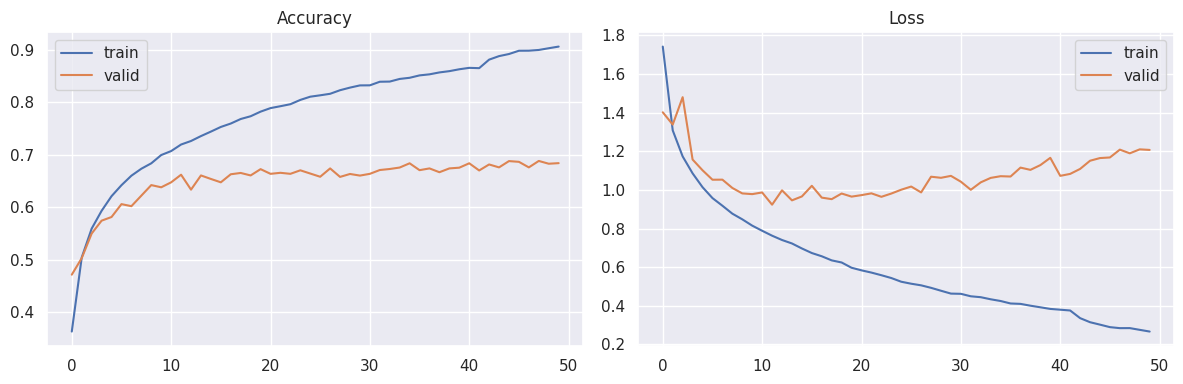

In [ ]:
plot_loss_acc_graphs(history)

In [ ]:
def plot_violin_graph(history):
  # Create dataframes for accuracy and loss values
  df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
  df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

  # Create a figure with two subplots for accuracy and loss
  fig = pyplot.figure(0, (14, 4))

  # Plot the violin plot for accuracy
  ax = pyplot.subplot(1, 2, 1)
  sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
  pyplot.title('Accuracy')
  pyplot.tight_layout()

  # Plot the violin plot for loss
  ax = pyplot.subplot(1, 2, 2)
  sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
  pyplot.title('Loss')
  pyplot.tight_layout()

  # Save the figure as 'performance_dist.png' and display the plot
  pyplot.savefig('violin_plot_vgg.png')
  pyplot.show()

In [ ]:
plot_violin_graph(history)

In [ ]:
#Using saved model
from keras.models import  model_from_json

json_file = open('/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_vgg19.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_vgg19.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
batch_size = 5
epochs = 10
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]
loaded_model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)

In [117]:
def plot_confusion_matrix(loaded_model, x_test, y_test, filename):
  # Predict class labels for the test dataset using the loaded model
  yhat_test = np.argmax(loaded_model.predict(x_test), axis=1)

  # Plot the confusion matrix using scikit-plot
  scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_test, figsize=(7,7))

  # Save the plotted confusion matrix as an image
  pyplot.savefig(filename)

  # Calculate and print the total number of wrong validation predictions
  print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test)}\n\n')

  # Generate a classification report based on true and predicted class labels
  print(classification_report(np.argmax(y_test, axis=1), yhat_test))

113/113 [==============================] - 2s 14ms/step
total wrong validation predictions: 1122


              precision    recall  f1-score   support

           0       0.66      0.60      0.63       491
           1       0.77      0.89      0.82        55
           2       0.55      0.62      0.58       528
           3       0.90      0.79      0.84       879
           4       0.51      0.62      0.56       594
           5       0.82      0.85      0.84       416
           6       0.68      0.61      0.64       626

    accuracy                           0.69      3589
   macro avg       0.70      0.71      0.70      3589
weighted avg       0.70      0.69      0.69      3589



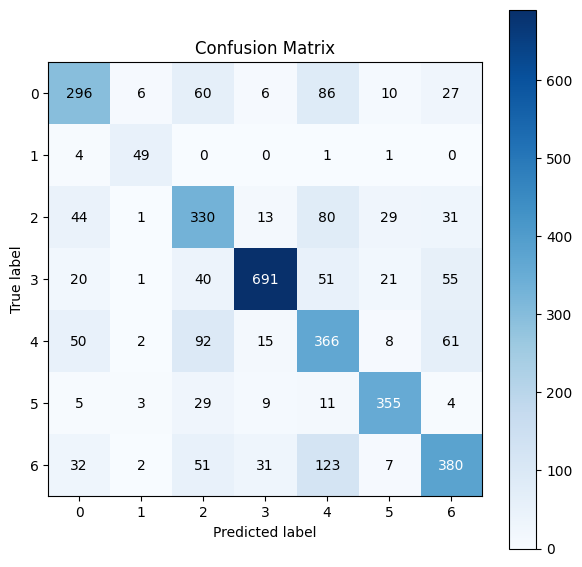

In [ ]:
plot_confusion_matrix(loaded_model, x_test, v_test, "confusion_matrix_vgg.png")

## With Hyperparameter tuning

In [102]:
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
from keras.layers import InputLayer

In [107]:
def vgg_hyp_model(hp):

  classes = 7

  # Create a VGG19 model with pre-trained weights from ImageNet
  vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))
  
  # Extract the output of the second-to-last layer of the bottom model
  output = vgg.layers[-2].output

  # Apply Global Average Pooling to reduce spatial dimensions
  output = GlobalAveragePooling2D()(output)
  
  # Add a Dense layer with softmax activation as the output layer
  output = Dense(classes, activation = 'softmax', name = 'out_layer')(output)

  # Create a new model by specifying the inputs and outputs
  model = Model(inputs = vgg.input, outputs = output)

  model.compile(loss = 'categorical_crossentropy', # Loss function for multi-class classification
              optimizer = optimizers.Nadam(learning_rate=hp.Choice('learning_rate',
                                            values=[1e-2, 1e-3, 1e-4]), beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='nadam'), # Selected optimizer from the optims list
              metrics = ['accuracy']) # Evaluation metric(s) to be computed during training
  
  return model

In [83]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Metric to monitor for early stopping
    min_delta=0.00005,                 # Minimum change in the monitored metric to be considered as improvement
    patience=11,                       # Number of epochs with no improvement after which training will be stopped
    verbose=1,                         # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
    restore_best_weights=True          # Whether to restore model weights from the epoch with the best monitored metric
)

# Create a ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',            # Metric to monitor for learning rate adjustment
    factor=0.5,                        # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=7,                        # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                       # Lower bound on the learning rate
    verbose=1                          # Verbosity mode. 0 = silent, 1 = update messages
)

# Combine the callbacks into a list
callbacks = [early_stopping, lr_scheduler]

In [108]:
# Define the hyperparameter search space
tuner_hp = HyperParameters()

# Configure the tuner
tuner = RandomSearch(
    vgg_hyp_model,
    objective='val_accuracy',
    max_trials=5,
    directory='/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/Model_VGG_Tuning_3',
    project_name='vgg')


In [109]:
# Search for the best hyperparameters
tuner.search(x_train, y_train,
            epochs=20,
            validation_data=(x_valid, y_valid),
            batch_size = tuner_hp.Choice('batch_size', [32, 64, 128]),
            steps_per_epoch=len(x_train) / tuner_hp.Choice('batch_size', [32, 64, 128]),
            callbacks=callbacks,
            use_multiprocessing=True,
            verbose = 0)

# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]  # Fetch best hyperparameter configuration


Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 1.
Epoch 12: early stopping

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Restoring model weights from the end of the best epoch: 1.
Epoch 12: early stopping


In [110]:
tuner.results_summary()

Results summary
Results in /content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/Model_VGG_Tuning_3/vgg
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
learning_rate: 0.0001
Score: 0.6937865614891052

Trial 2 summary
Hyperparameters:
learning_rate: 0.01
Score: 0.16912789642810822

Trial 1 summary
Hyperparameters:
learning_rate: 0.001
Score: 0.13569238781929016


In [112]:
# Build and train the final model
final_model = tuner.hypermodel.build(best_hp)
history  =  final_model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
1743/1743 [==============================] - 41s 22ms/step - loss: 1.2378 - accuracy: 0.5209 - val_loss: 1.2180 - val_accuracy: 0.5486
Epoch 2/20
1743/1743 [==============================] - 39s 22ms/step - loss: 0.8977 - accuracy: 0.6613 - val_loss: 1.7252 - val_accuracy: 0.4840
Epoch 3/20
1743/1743 [==============================] - 38s 22ms/step - loss: 0.7604 - accuracy: 0.7169 - val_loss: 1.0026 - val_accuracy: 0.6311
Epoch 4/20
1743/1743 [==============================] - 38s 22ms/step - loss: 0.6332 - accuracy: 0.7658 - val_loss: 0.9967 - val_accuracy: 0.6539
Epoch 5/20
1743/1743 [==============================] - 38s 22ms/step - loss: 0.5047 - accuracy: 0.8175 - val_loss: 1.0595 - val_accuracy: 0.6545
Epoch 6/20
1743/1743 [==============================] - 38s 22ms/step - loss: 0.3785 - accuracy: 0.8651 - val_loss: 1.0516 - val_accuracy: 0.6679
Epoch 7/20
1743/1743 [==============================] - 38s 22ms/step - loss: 0.2813 - accuracy: 0.9024 - val_loss: 1.3302 -

In [113]:
# Saving model and weights 
model_json = final_model.to_json()
with open("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_cnn_best_vgg_1.json", "w") as json_file:
    json_file.write(model_json)
    
final_model.save("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_cnn_best_vgg_1.h5")

In [114]:
final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

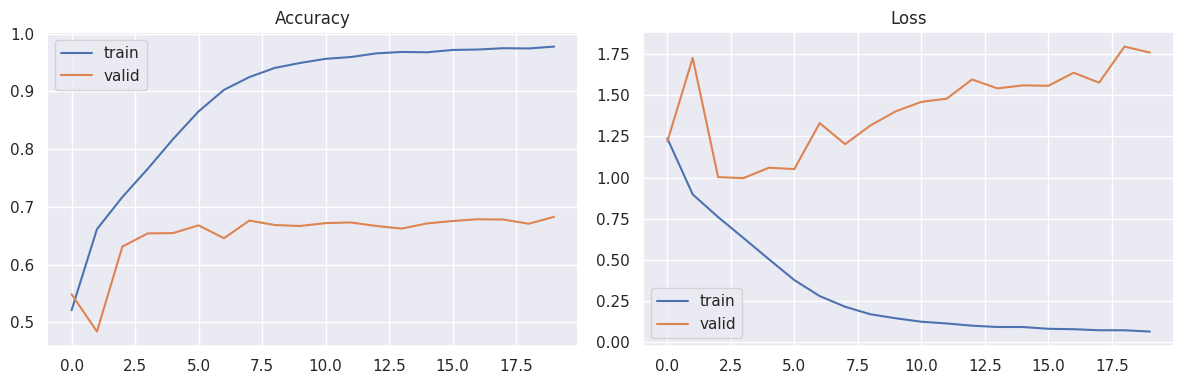

In [115]:
plot_loss_acc_graphs(history)

113/113 [==============================] - 1s 5ms/step
total wrong validation predictions: 1128


              precision    recall  f1-score   support

           0       0.61      0.67      0.64       491
           1       0.76      0.82      0.79        55
           2       0.66      0.48      0.55       528
           3       0.86      0.84      0.85       879
           4       0.52      0.56      0.54       594
           5       0.79      0.83      0.81       416
           6       0.62      0.68      0.64       626

    accuracy                           0.69      3589
   macro avg       0.69      0.70      0.69      3589
weighted avg       0.69      0.69      0.68      3589



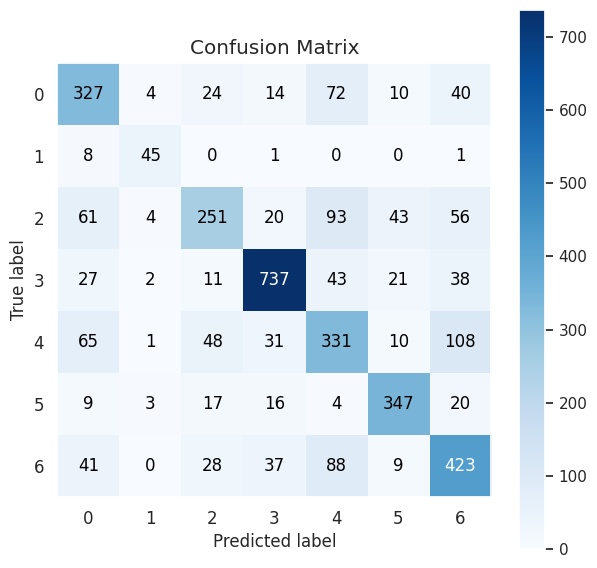

In [118]:
plot_confusion_matrix(final_model, x_test, y_test, "confusion_matrix_vgg_best_1.png")

##Convoltutional Neural Network

In [ ]:
!pip install scikit-plot

In [ ]:
# Impot the necesaary libraries
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import optimizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [16]:
def build_net(optim):
    """
    Build a deep convolutional neural network model.

    Parameters:
    - optim: The optimizer used for training the model.

    Returns:
    - net: The built deep convolutional neural network model.

    Conv2D layers' arguments:

    filter: No. of filters to be applied
    kernel_zie: size of each filter.
    input_shape: Shape of input image. In our case it is (48, 48, 3)
    activation: ELU Activation function. It is a variant f ReLU activation function.
    padding: Here, 'same' means input and output shape will be same. Basically 0 padding
    kernel_initializer: 'he_normal' is used to initialize weights ( normal distribution )
    name: Name of resepective layer

    """
    num_classes = 7 # no. of emotion_labels
    net = Sequential(name='DCNN') #name of network or model

    # Dense Layer 1 ( Input Layer )
    net.add(
        Conv2D(
            filters=64,               
            kernel_size=(5,5),        
            input_shape=(48, 48, 3), 
            activation='elu',           
            padding='same',            
            kernel_initializer='he_normal', 
            name='conv2d_1'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_1')) 

    # Dense Layer 2
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_2'))
    
    # Max Pooling 
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))

    # Droputs applied to reduce overfitting
    # 40% of the input units will be randomly set to 0 during training.
    net.add(Dropout(0.4, name='dropout_1'))

    # Dense Layer 3
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_3'))

    # Dense Layer 4
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_4'))
    
    # Max Pooling
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))

    # 40% Dropouts
    net.add(Dropout(0.4, name='dropout_2'))

    # Dense Layer 5
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_5'))

    # Dense Layer 6
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_6'))
    
    # Max pooling
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))

    # 50% dropouts
    net.add(Dropout(0.5, name='dropout_3'))

    #Flatten the 2D convolutions
    net.add(Flatten(name='flatten'))
        
    # Dense Layer 7 containing 128 neurons
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_7'))
    
    # 60% dropouts
    net.add(Dropout(0.6, name='dropout_4'))
    
    # Dense Layer 8 - Output Layer containing 7 neurons that must be equal to the number of classes
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    # Compile the model
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    #net.summary()
    
    return net

In [ ]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Metric to monitor for early stopping
    min_delta=0.00005,                 # Minimum change in the monitored metric to be considered as improvement
    patience=11,                       # Number of epochs with no improvement after which training will be stopped
    verbose=1,                         # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
    restore_best_weights=True          # Whether to restore model weights from the epoch with the best monitored metric
)

# Create a ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',            # Metric to monitor for learning rate adjustment
    factor=0.5,                        # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=7,                        # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                       # Lower bound on the learning rate
    verbose=1                          # Verbosity mode. 0 = silent, 1 = update messages
)

# Combine the callbacks into a list
callbacks = [early_stopping, lr_scheduler]

In [ ]:
batch_size = 32
epochs = 50
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) 
history = model.fit(
    x_train, y_train, batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [ ]:
# Saving model and weights 
model_json = model.to_json()
with open("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_cnn.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_cnn.h5")

In [55]:
def plot_loss_acc_graphs(history):
  # Set the style for the plots
  sns.set()

  # Create a figure with two subplots for accuracy and loss
  fig = pyplot.figure(0, (12, 4))

  # Plot the training and validation accuracy
  ax = pyplot.subplot(1, 2, 1)
  sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
  sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
  pyplot.title('Accuracy')
  pyplot.tight_layout()

  # Plot the training and validation loss
  ax = pyplot.subplot(1, 2, 2)
  sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
  sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
  pyplot.title('Loss')
  pyplot.tight_layout()

  # Save the figure as 'epoch_history_dcnn.png' and display the plot
  pyplot.savefig('epoch_history_vgg.png')
  pyplot.show()

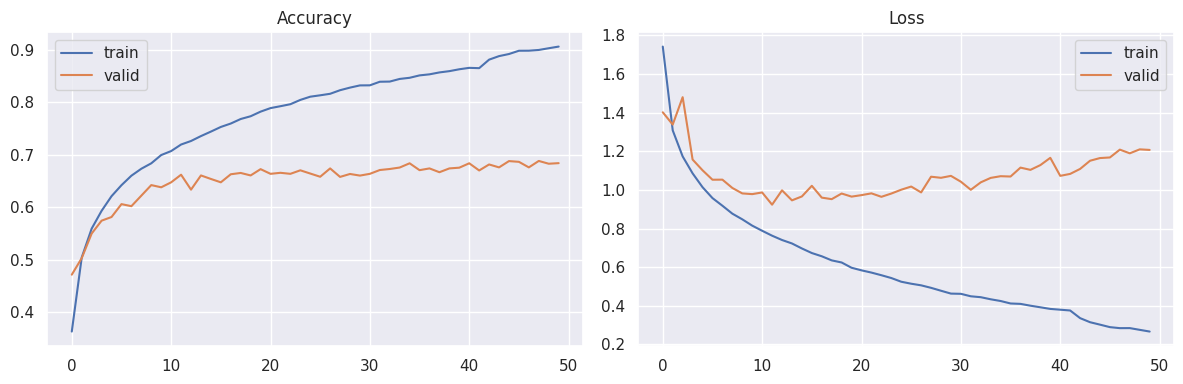

In [ ]:
plot_loss_acc_graphs(history)

In [54]:
def plot_violin_graph(history):
  # Create dataframes for accuracy and loss values
  df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
  df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

  # Create a figure with two subplots for accuracy and loss
  fig = pyplot.figure(0, (14, 4))

  # Plot the violin plot for accuracy
  ax = pyplot.subplot(1, 2, 1)
  sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
  pyplot.title('Accuracy')
  pyplot.tight_layout()

  # Plot the violin plot for loss
  ax = pyplot.subplot(1, 2, 2)
  sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
  pyplot.title('Loss')
  pyplot.tight_layout()

  # Save the figure as 'performance_dist.png' and display the plot
  pyplot.savefig('violin_plot_vgg.png')
  pyplot.show()

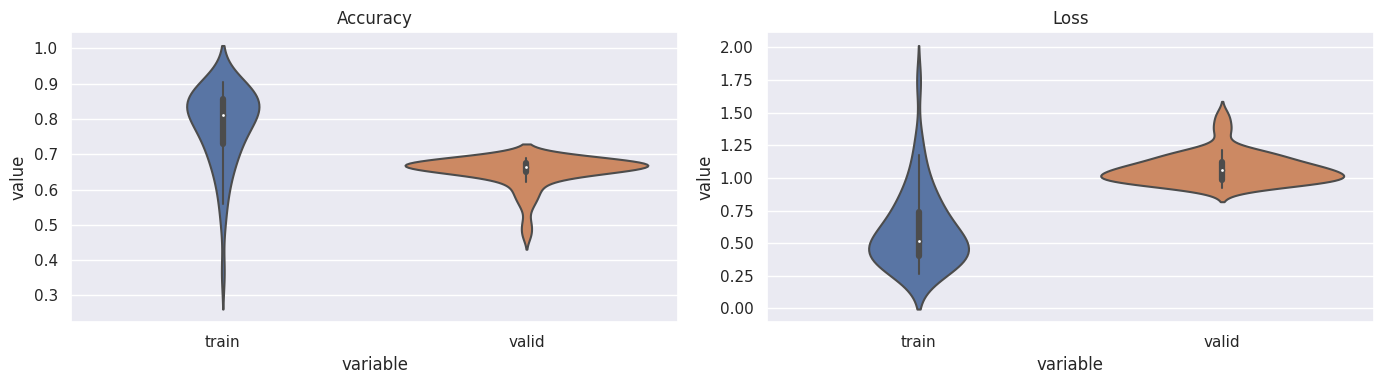

In [ ]:
plot_violin_graph(history)

In [60]:
def plot_confusion_matrix(model, x_test, y_test, filename):
  # Predict class labels for the test dataset using the loaded model
  yhat_test = np.argmax(model.predict(x_test), axis=1)

  # Plot the confusion matrix using scikit-plot
  scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_test, figsize=(7,7))

  # Save the plotted confusion matrix as an image
  pyplot.savefig(filename)

  # Calculate and print the total number of wrong validation predictions
  print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test)}\n\n')

  # Generate a classification report based on true and predicted class labels
  print(classification_report(np.argmax(y_test, axis=1), yhat_test))

113/113 [==============================] - 1s 7ms/step
total wrong validation predictions: 1068


              precision    recall  f1-score   support

           0       0.65      0.64      0.64       491
           1       0.86      0.89      0.88        55
           2       0.59      0.56      0.58       528
           3       0.90      0.86      0.88       879
           4       0.57      0.52      0.54       594
           5       0.79      0.86      0.82       416
           6       0.62      0.69      0.66       626

    accuracy                           0.70      3589
   macro avg       0.71      0.72      0.71      3589
weighted avg       0.70      0.70      0.70      3589



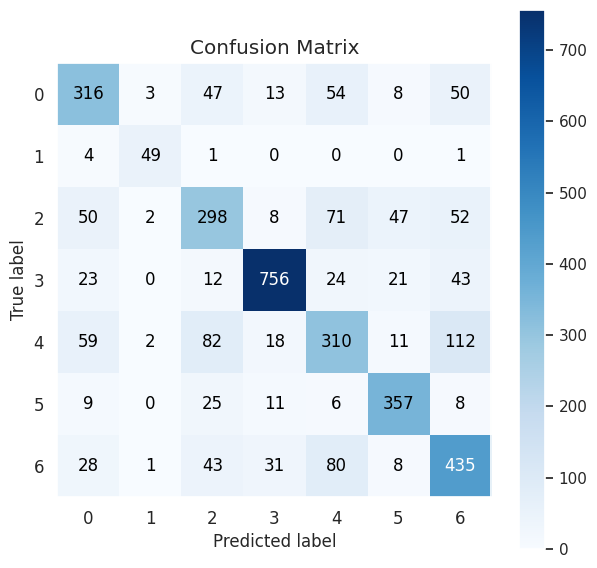

In [ ]:
plot_confusion_matrix(model, x_test, y_test, "confusion_matrix_dcnn.png")

## With Hyperparamter Tuning

In [17]:
! pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.5 MB/s eta 0:00:00


In [29]:
# Impot the necesaary libraries
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import optimizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
from keras.layers import InputLayer

In [119]:
def build_model_new(hp):
    """
    Build a deep convolutional neural network model.

    Parameters:
    - optim: The optimizer used for training the model.

    Returns:
    - net: The built deep convolutional neural network model.

    Conv2D layers' arguments:

    filter: No. of filters to be applied
    kernel_zie: size of each filter.
    input_shape: Shape of input image. In our case it is (48, 48, 3)
    activation: ELU Activation function. It is a variant f ReLU activation function.
    padding: Here, 'same' means input and output shape will be same. Basically 0 padding
    kernel_initializer: 'he_normal' is used to initialize weights ( normal distribution )
    name: Name of resepective layer

    """
    num_classes = 7 # no. of emotion_labels
    net = Sequential(name='DCNN') #name of network or model
    # Dense Layer 1 ( Input Layer )
    kernel_size_1 = hp.Int('kernel_size_1', min_value=3, max_value=7, step=2)
    net.add(
          Conv2D(
              filters=hp.Int('filters_1', min_value=64, max_value=256, step=32),               
              kernel_size=(kernel_size_1,kernel_size_1),        
              input_shape=(48, 48, 3), 
              activation='elu',           
              padding='same',            
              kernel_initializer='he_normal', 
              name='conv2d_1'
          )
      )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_1')) 

    # Dense Layer 2
    kernel_size_2 = hp.Int('kernel_size_2', min_value=3, max_value=7, step=2)
    net.add(
        Conv2D(
            filters=hp.Int('filters_2', min_value=64, max_value=256, step=32),
            kernel_size=(kernel_size_2,kernel_size_2),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_2'))
    
    # Max Pooling 
    max_pool_size_1 = hp.Int('max_pool_size_1', min_value=2, max_value=3, step=2)
    net.add(MaxPooling2D(pool_size=(max_pool_size_1,max_pool_size_1), name='maxpool2d_1'))

    # Droputs applied to reduce overfitting
    # 40% of the input units will be randomly set to 0 during training.
    net.add(Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1), name='dropout_1'))

    # Dense Layer 3
    kernel_size_3 = hp.Int('kernel_size_3', min_value=3, max_value=7, step=2)
    net.add(
        Conv2D(
            filters=hp.Int('filters_3', min_value=64, max_value=256, step=32),
            kernel_size=(kernel_size_3,kernel_size_3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_3'))

    # Dense Layer 4
    kernel_size_4 = hp.Int('kernel_size_4', min_value=3, max_value=7, step=2)
    net.add(
        Conv2D(
            filters=hp.Int('filters_4', min_value=128, max_value=256, step=32),
            kernel_size=(kernel_size_4,kernel_size_4),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_4'))
      
    # Max Pooling
    max_pool_size_2 = hp.Int('max_pool_size_2', min_value=2, max_value=3, step=2)
    net.add(MaxPooling2D(pool_size=(max_pool_size_2,max_pool_size_2), name='maxpool2d_2'))

    # Dropouts
    net.add(Dropout(hp.Float('dropout_rate_2', min_value=0.3, max_value=0.5, step=0.1), name='dropout_2'))

    # Dense Layer 5
    kernel_size_5 = hp.Int('kernel_size_5', min_value=3, max_value=7, step=2)
    net.add(
        Conv2D(
            filters=hp.Int('filters_5', min_value=128, max_value=256, step=32),
            kernel_size=(kernel_size_5,kernel_size_5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_5'))

    # Dense Layer 6
    kernel_size_6 = hp.Int('kernel_size_6', min_value=3, max_value=7, step=2)
    net.add(
        Conv2D(
            filters=hp.Int('filters_6', min_value=128, max_value=256, step=32),
            kernel_size=(kernel_size_6,kernel_size_6),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_6'))
    
    # Max pooling
    max_pool_size_3 = hp.Int('max_pool_size_3', min_value=2, max_value=5, step=2)
    net.add(MaxPooling2D(pool_size=(max_pool_size_3,max_pool_size_3), name='maxpool2d_3'))

    # dropouts
    net.add(Dropout(hp.Float('dropout_rate_3', min_value=0.5, max_value=0.7, step=0.1), name='dropout_3'))

    #Flatten the 2D convolutions
    net.add(Flatten(name='flatten'))
        
    # Dense Layer 7 containing 128 neurons
    net.add(
        Dense(
            units=hp.Int('filters_7', min_value=128, max_value=256, step=32),
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )

    # Batch normalization
    net.add(BatchNormalization(name='batchnorm_7'))
      
    # dropouts
    net.add(Dropout(hp.Float('dropout_rate_4', min_value=0.5, max_value=0.8, step=0.1), name='dropout_4'))
    
    # Dense Layer 8 - Output Layer containing 7 neurons that must be equal to the number of classes
    net.add(
        Dense(
            units=num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    # Compile the model
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate',
                                            values=[1e-2, 1e-3, 1e-4])),
        metrics=['accuracy']
    )
    
    #net.summary()
    
    return net

In [34]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Metric to monitor for early stopping
    min_delta=0.00005,                 # Minimum change in the monitored metric to be considered as improvement
    patience=11,                       # Number of epochs with no improvement after which training will be stopped
    verbose=1,                         # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
    restore_best_weights=True          # Whether to restore model weights from the epoch with the best monitored metric
)

# Create a ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',            # Metric to monitor for learning rate adjustment
    factor=0.5,                        # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=7,                        # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                       # Lower bound on the learning rate
    verbose=1                          # Verbosity mode. 0 = silent, 1 = update messages
)

# Combine the callbacks into a list
callbacks = [early_stopping, lr_scheduler]

In [120]:
# Define the hyperparameter search space
tuner_hp = HyperParameters()

In [121]:
# Configure the tuner
tuner = RandomSearch(
    build_model_new,
    objective='val_accuracy',
    max_trials=5,
    directory='/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/Model_Tuning_dcnn',
    project_name='dcnn')

In [122]:
# Search for the best hyperparameters
tuner.search(x_train, y_train,
            epochs=50,
            validation_data=(x_valid, y_valid),
            batch_size = tuner_hp.Choice('batch_size', [32, 64, 128]),
            steps_per_epoch=len(x_train) / tuner_hp.Choice('batch_size', [32, 64, 128]),
            callbacks=callbacks,
            use_multiprocessing=True,
            verbose = 0)

# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]  # Fetch best hyperparameters


Epoch 28: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 35: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 44: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 45: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


In [123]:
tuner.results_summary()

Results summary
Results in /content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/Model_Tuning_dcnn/dcnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
kernel_size_1: 5
filters_1: 64
kernel_size_2: 7
filters_2: 192
max_pool_size_1: 2
dropout_rate_1: 0.30000000000000004
kernel_size_3: 7
filters_3: 192
kernel_size_4: 5
filters_4: 192
max_pool_size_2: 2
dropout_rate_2: 0.3
kernel_size_5: 5
filters_5: 224
kernel_size_6: 7
filters_6: 160
max_pool_size_3: 2
dropout_rate_3: 0.6
filters_7: 192
dropout_rate_4: 0.8
learning_rate: 0.01
Score: 0.6957369446754456

Trial 3 summary
Hyperparameters:
kernel_size_1: 5
filters_1: 64
kernel_size_2: 3
filters_2: 160
max_pool_size_1: 2
dropout_rate_1: 0.2
kernel_size_3: 7
filters_3: 256
kernel_size_4: 7
filters_4: 128
max_pool_size_2: 2
dropout_rate_2: 0.3
kernel_size_5: 3
filters_5: 256
kernel_size_6: 7
filters_6: 160
max_pool_size_3: 2
dropout_rate_3: 0.6
filters_7: 224
dropout_rate_4: 0.7
learning_

In [124]:
# Build and train the final model
final_model = tuner.hypermodel.build(best_hp)
history  =  final_model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50
1743/1743 [==============================] - 43s 24ms/step - loss: 1.9615 - accuracy: 0.2310 - val_loss: 2.1264 - val_accuracy: 0.2903
Epoch 2/50
1743/1743 [==============================] - 41s 23ms/step - loss: 1.5088 - accuracy: 0.4198 - val_loss: 1.4906 - val_accuracy: 0.4193
Epoch 3/50
1743/1743 [==============================] - 41s 24ms/step - loss: 1.2954 - accuracy: 0.5134 - val_loss: 1.6403 - val_accuracy: 0.3870
Epoch 4/50
1743/1743 [==============================] - 41s 24ms/step - loss: 1.1791 - accuracy: 0.5609 - val_loss: 1.3554 - val_accuracy: 0.5185
Epoch 5/50
1743/1743 [==============================] - 41s 23ms/step - loss: 1.0874 - accuracy: 0.6006 - val_loss: 1.1076 - val_accuracy: 0.5901
Epoch 6/50
1743/1743 [==============================] - 41s 24ms/step - loss: 1.0145 - accuracy: 0.6310 - val_loss: 1.0813 - val_accuracy: 0.5890
Epoch 7/50
1743/1743 [==============================] - 41s 24ms/step - loss: 0.9502 - accuracy: 0.6543 - val_loss: 1.2399 -

In [125]:
# Best Hyperparameters 
final_model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 192)       602304    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 192)      768       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 192)       0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 192)       0      

In [126]:
# Saving model and weights 
model_json = final_model.to_json()
with open("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_cnn_best_hyp_1.json", "w") as json_file:
    json_file.write(model_json)
    
final_model.save("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_cnn_best_hyp_1.h5")

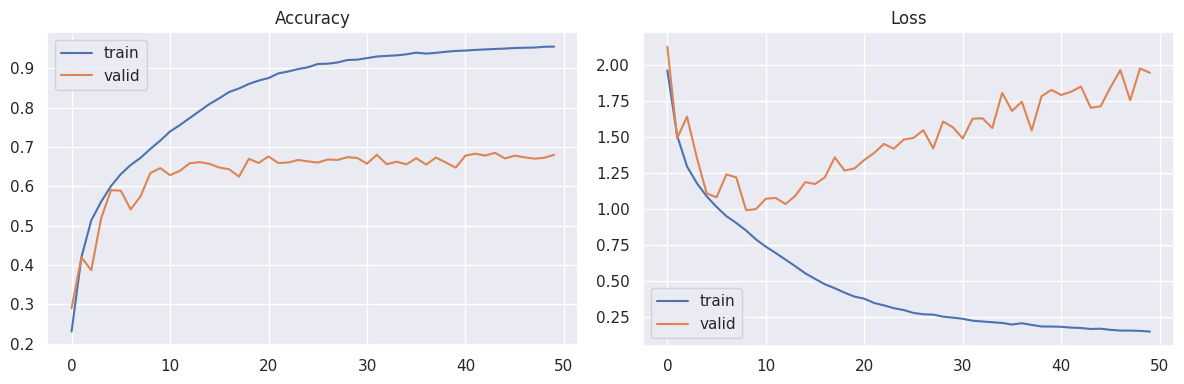

In [127]:
plot_loss_acc_graphs(history)

113/113 [==============================] - 1s 6ms/step
total wrong validation predictions: 1102


              precision    recall  f1-score   support

           0       0.72      0.57      0.63       491
           1       0.81      0.93      0.86        55
           2       0.57      0.57      0.57       528
           3       0.92      0.80      0.85       879
           4       0.50      0.60      0.54       594
           5       0.85      0.84      0.84       416
           6       0.63      0.71      0.67       626

    accuracy                           0.69      3589
   macro avg       0.71      0.72      0.71      3589
weighted avg       0.71      0.69      0.70      3589



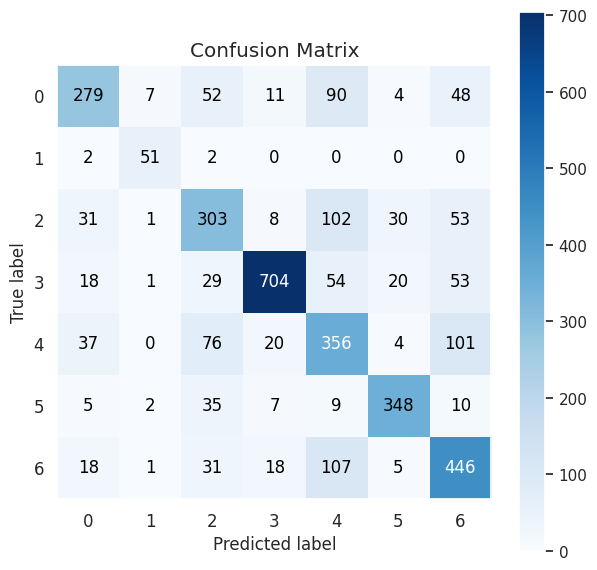

In [128]:
plot_confusion_matrix(final_model, x_test, y_test, "confusion_matrix_dcnn_best_1.png")

## Vision Transformer: ViT_B16

In [129]:
#Install libraries
!pip install tensorflow-addons
!pip install vit_keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=3bf5f34fd8c5ce49832df14ffcfd11f45ece660ffece632d276173a59da51ba5
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [130]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [145]:
def vit_model(num_classes, image_size):
  """
    Create a Vision Transformer (ViT) model using the ViT-B16 architecture.

    Args:
        num_classes (int): Number of output classes for classification.
        image_size (int): Size of the input image (both width and height).

    Returns:
        tf.keras.Model: Compiled ViT model.

    """
  # Load ViT-B16 model with specified configurations
  vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes)
  
  # Create a sequential model
  model = tf.keras.Sequential([
        # Add the ViT-B16 model as the base model
        vit_model,
        # Flatten the output for further processing
        tf.keras.layers.Flatten(),
        # Apply batch normalization to normalize the input
        tf.keras.layers.BatchNormalization(),
        # Add a dense layer with 128 units and GELU activation
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        # Apply batch normalization
        tf.keras.layers.BatchNormalization(),
        # Add another dense layer with 64 units and GELU activation
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        # Add the final dense layer with 7 units and softmax activation for classification
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'vision_transformer')

  # Compile the model with specified optimizer, loss function, and metrics
  model.compile(optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.001), 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])
  
  # Return the compiled model
  return model

In [132]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        """
        Custom layer to extract patches from images.

        Args:
            patch_size (int): Size of the square patch.

        """
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):

        """
        Apply patch extraction to the input images.

        Args:
            images (tf.Tensor): Input images.

        Returns:
            tf.Tensor: Extracted patches from the images.

        """
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
def show_patches( patch_size, image):
  """
    Display the patches extracted from an image.

    Args:
        patch_size (int): Size of the square patch.
        image (numpy.ndarray): Input image.

  """

  plt.figure(figsize=(4, 4))
  num_patches = (48 // patch_size) ** 2

  plt.imshow(image)
  plt.axis('off')

  resized_image = tf.image.resize(
      tf.convert_to_tensor([image]), size = (image.shape[0], image.shape[1])
  )

  patches = Patches(patch_size)(resized_image)
  print(f'Image size: {48} X {48}')
  print(f'Patch size: {patch_size} X {patch_size}')
  print(f'Patches per image: {patches.shape[1]}')
  print(f'Elements per patch: {patches.shape[-1]}')

  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(4, 4))

  for i, patch in enumerate(patches[0]):
      ax = plt.subplot(n, n, i + 1)
      patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
      plt.imshow(patch_img.numpy())
      plt.axis('off')

Image size: 48 X 48
Patch size: 6 X 6
Patches per image: 64
Elements per patch: 108


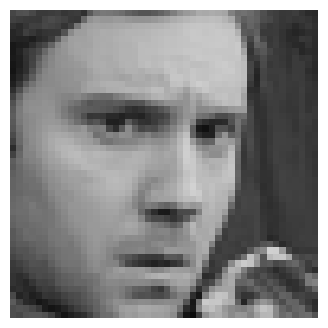

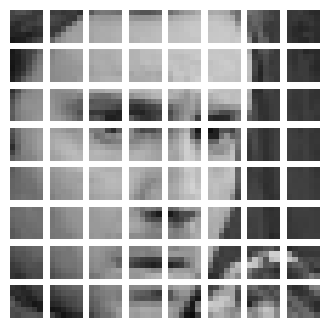

In [137]:
show_patches(6, x_train[0])

In [138]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',            # Metric to monitor for early stopping
    min_delta=0.00005,                 # Minimum change in the monitored metric to be considered as improvement
    patience=11,                       # Number of epochs with no improvement after which training will be stopped
    verbose=1,                         # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
    restore_best_weights=True          # Whether to restore model weights from the epoch with the best monitored metric
)

# Create a ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',            # Metric to monitor for learning rate adjustment
    factor=0.5,                        # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=7,                        # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                       # Lower bound on the learning rate
    verbose=1                          # Verbosity mode. 0 = silent, 1 = update messages
)

# Combine the callbacks into a list
callbacks = [early_stopping, lr_scheduler]

In [146]:
image_size = 48 # size of image
num_classes = 7 # number of emotion classes

model = vit_model(num_classes, image_size) # building model 
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85655040  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)               98432     
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 64)         

In [148]:
warnings.filterwarnings("ignore")

epochs = 50                                                 
batch_size = 64 

history  = model.fit(x_train, y_train,
          steps_per_epoch = len(x_train) // batch_size,
          validation_data = (x_valid, y_valid),
          epochs = epochs,
          callbacks = callbacks,
          use_multiprocessing=True)

Epoch 1/50
871/871 [==============================] - 105s 103ms/step - loss: 1.7200 - accuracy: 0.4115 - val_loss: 1.7093 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 2/50
871/871 [==============================] - 86s 99ms/step - loss: 1.4843 - accuracy: 0.5477 - val_loss: 1.6381 - val_accuracy: 0.4907 - lr: 0.0010
Epoch 3/50
871/871 [==============================] - 86s 98ms/step - loss: 1.4313 - accuracy: 0.5866 - val_loss: 1.5556 - val_accuracy: 0.5085 - lr: 0.0010
Epoch 4/50
871/871 [==============================] - 86s 99ms/step - loss: 1.4082 - accuracy: 0.5997 - val_loss: 1.5528 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 5/50
871/871 [==============================] - 86s 98ms/step - loss: 1.3950 - accuracy: 0.6095 - val_loss: 1.6212 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 6/50
871/871 [==============================] - 86s 98ms/step - loss: 1.3799 - accuracy: 0.6193 - val_loss: 1.6216 - val_accuracy: 0.4826 - lr: 0.0010
Epoch 7/50
871/871 [==============================] - 86

871/871 [==============================] - 24s 28ms/step - loss: 0.8397 - accuracy: 0.9579 - val_loss: 1.5927 - val_accuracy: 0.6133 - lr: 0.0010


In [149]:
# Saving model and weights 
model_json = model.to_json()
with open("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_vit_1.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("/content/MyDrive/MyDrive/Facial_Exp_Detection/fer2013/model_vit_1.h5")

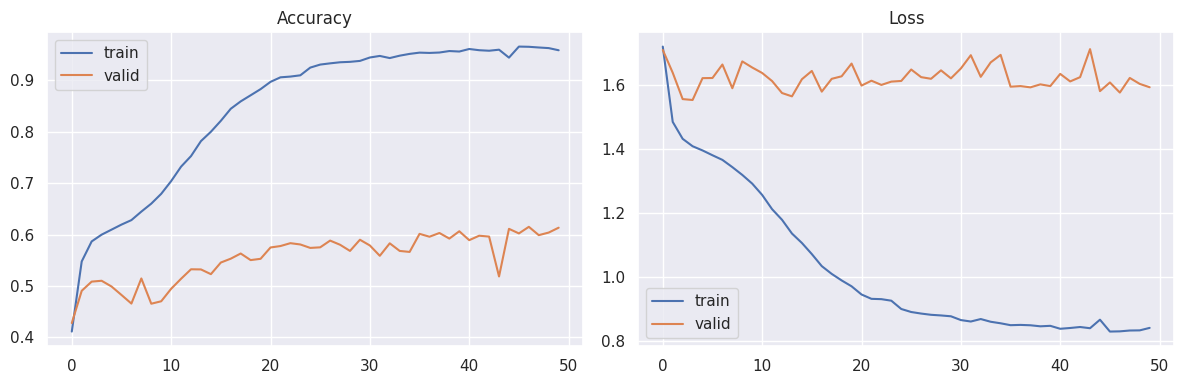

In [150]:
# plot the graphs of loss and accuracy
plot_loss_acc_graphs(history)

113/113 [==============================] - 7s 30ms/step
total wrong validation predictions: 1347


              precision    recall  f1-score   support

           0       0.61      0.55      0.58       491
           1       0.65      0.85      0.74        55
           2       0.57      0.56      0.56       528
           3       0.75      0.69      0.72       879
           4       0.46      0.57      0.51       594
           5       0.77      0.80      0.78       416
           6       0.60      0.56      0.58       626

    accuracy                           0.62      3589
   macro avg       0.63      0.65      0.64      3589
weighted avg       0.63      0.62      0.63      3589



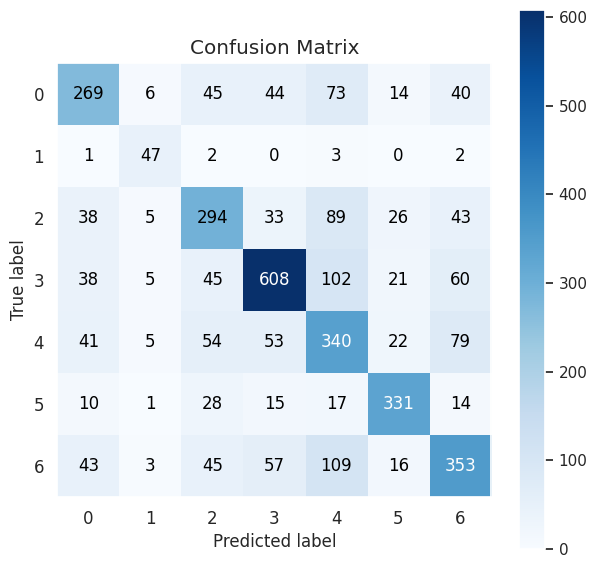

In [152]:
# plot confusion matrix
plot_confusion_matrix(model, x_test, y_test, "confusion_matrix_vit_1.png")